# Objectives
### 1. To practice the application of descriptive and inferential Statistics 101 tools to COVID-19 data.
### 2. In specific, we will look at mortality rate statistics across time and across regions in Brazil. Our primary data is quantative and discrete, as they pertain to total cases, total deaths, and total population. Such data are double-indexed by both municipality and date.

# Kernel setup

### We begin by importing useful modules, importing our cleaned datasets, and merging them.

In [1]:
import os
import time
import math
import pickle
import numpy as np
import pandas as pd
from scipy.stats import norm
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt

In [2]:
save_path = 'data' + os.sep + 'processed' + os.sep
JanJul2020 = pd.read_pickle(f'{save_path}JanJul2020')
AugDec2020 = pd.read_pickle(f'{save_path}AugDec2020')
JanJul2021 = pd.read_pickle(f'{save_path}JanJul2021')

In [3]:
JanJul2020 = JanJul2020.append(AugDec2020)
JanJul2020 = JanJul2020.append(JanJul2021)
df = JanJul2020

### We follow-up by defining useful statistical descriptive functions.

In [4]:
def get_mean(values):
    return sum(values) / len(values)


def get_25th_percentile(values):
    values.sort()
    factor = 1/4
    return values[int(factor * len(values))]


def get_50th_percentile(values):
    values.sort()
    factor = 1/2
    return values[int(factor * len(values))]


def get_75th_percentile(values):
    values.sort()
    factor = 3/4
    return values[int(factor * len(values))]


def get_outliers(values):
    values.sort()
    
    lower_quartile = get_25th_percentile(values)
    median = get_50th_percentile(values)
    upper_quartile = get_75th_percentile(values)
    interquartile_range = upper_quartile - lower_quartile
    
    outlier_range = 1.5 * interquartile_range
    outlier_limit_lower = lower_quartile - outlier_range
    outlier_limit_upper = upper_quartile + outlier_range
    
    lower_outliers = [value for value in values if value < outlier_limit_lower]
    upper_outliers = [value for value in values if value > outlier_limit_upper]
    return lower_outliers, upper_outliers


def get_variance(values):
    mean = get_mean(values)
    return sum([(value - mean) ** 2 for value in values]) / len(values)


def get_std(values):
    variance = get_variance(values)
    return math.sqrt(variance)

### Our dataset can be efficiently indexed for single values, although its huge size makes whole-dataset parsing take a few minutes.

In [5]:
def get_value(df, place, date, colname):
    return int(np.sum(df.loc[place].loc[date][colname]))

city = 'Belém'
date = '2021-01-01'
start = time.time()
value = get_value(df, city, date, 'Death rate')
end = time.time()
print(f"There were {value} accumulated deaths per million in {city} at {date}. Info retrieved in {end - start : .4f} seconds.")

There were 3343 accumulated deaths per million in Belém at 2021-01-01. Info retrieved in  0.0490 seconds.


# Exploratory analysis

## A) Zero-death municipalities

### We have noticed that many cities have registered zero deaths during the brazilian COVID-19 epidemic, although no city has registered zero COVID-19 _cases_.

In [6]:
def get_zeros(df, colname):
    zeros = list()
    cities = df.index.unique(level='City')
    for city in cities:
        val = get_value(df, city, '2021-06-08', colname)
        if val == 0:
            zeros.append(city)
    return zeros

zero_case = get_zeros(df, 'Total cases')
zero_death = get_zeros(df, 'Total deaths')
print(f"List of zero-case municipalities: {zero_case}.")
print(f"List of zero-death municipalities: {zero_death}.")

List of zero-case municipalities: [].
List of zero-death municipalities: ['Crixás do Tocantins', 'Lavandeira', 'Mateiros', 'Sucupira', 'Taipas do Tocantins', 'Santa Filomena do Maranhão', 'Massapê do Piauí', 'São Luis do Piauí', 'Bodó', 'Galinhos', 'Santana do Seridó', 'Algodão de Jandaíra', 'Bernardino Batista', 'Cajazeirinhas', 'Riachão do Bacamarte', 'Aricanduva', 'Bertópolis', 'Bonito de Minas', 'Campo Azul', 'Carmésia', 'Cedro do Abaeté', 'Diogo de Vasconcelos', 'Estrela do Indaiá', 'Fama', 'José Gonçalves de Minas', 'Miravânia', 'Patis', 'Pedra do Anta', 'Pedro Teixeira', 'Santana dos Montes', 'Santo Hipólito', 'Serra Azul de Minas', 'Serra da Saudade', 'Serranos', 'Veredinha', 'Bento de Abreu', 'Fernão', 'Sagres', "São João do Pau d'Alho", 'Boa Esperança do Iguaçu', 'Flor do Sertão', 'André da Rocha', 'Benjamin Constant do Sul', 'Guabiju', 'Novo Tiradentes', 'Pedras Altas', 'Araguainha', 'Amaralina', 'Guarani de Goiás', 'Nova Roma', "Sítio d'Abadia", 'Teresina de Goiás'].


### Our hypothesis is that such "zero-death" municipalities are too small and poor to harbor health care facilities adequate for COVID-19 treatment, and so has sent their serious COVID-19 patients to larger neighbouring cities.

### We can obtain some evidence for our hypothesis by comparing the average population of zero-death cities with the remaining cities. Zero-death cities are over a dozen times smaller!

### An alternative hypothesis is that larger cities are more densely-populated and thus viruses spread more easily.

In [7]:
cities = df.index.unique(level='City')
zero_death_popsizes = [get_value(df, city, '2021-06-08', 'Population') for city in zero_death]
nonzero_death_popsizes = [get_value(df, city, '2021-06-08', 'Population') for city in cities if city not in zero_death]

In [8]:
print(f"Zero-death cities have an average population of {get_mean(zero_death_popsizes):.0f} persons.")
print(f"The remaining cities have an average population of {get_mean(nonzero_death_popsizes):.0f} persons.")

Zero-death cities have an average population of 3224 persons.
The remaining cities have an average population of 40034 persons.


## B) Death rate distribution

### We can obtain a list of all death rates, one for each municipality, in just under a minute. We consider the last date available in our dataset: 8th of June of 2021.

In [9]:
def get_values(df, date, colname):
    value_list = list()
    cities = df.index.unique(level='City')
    for city in cities:
        value_list.append(get_value(df, city, date, colname))
    return value_list

In [10]:
start = time.time()
death_rates = get_values(df, '2021-06-08', 'Death rate')
end = time.time()
print(f"Obtained death rates list in {end - start :.0f} seconds.")

Obtained death rates list in 57 seconds.


### The country-wide average death rate was 2250 deaths per million population in 8th of June of 2021. This figure was obtained by dividing the 477 thousand total deaths [source](https://www.worldometers.info/coronavirus/country/brazil/) by the country's population of 211 million.

### Across municipalities, the average death rate is 1762, significantly below the country-wide death rate. This suggests that larger municipalities (bearing greater weight on a country-wide evaluation) have much higher death rates than small municipalities. We will examine this below.

### Notice also that the mean death rate is 0.15 standard deviations above the median, suggesting that the distribution is right-skewed. This suggests that a small number of municipalities have very large death rates. We also believe these to be the largest municipalities in the country.

In [11]:
print(f"Average death rate: {get_mean(death_rates) :.0f} deaths per million.")
print(f"25th percentile death rate: {get_25th_percentile(death_rates)} deaths per million.")
print(f"50th percentile death rate: {get_50th_percentile(death_rates)} deaths per million.")
print(f"75th percentile death rate: {get_75th_percentile(death_rates)} deaths per million.")
print(f"Dataset variance: {get_variance(death_rates) :.0f} deaths per million.")
print(f"Dataset standard deviation: {get_std(death_rates) :.0f} deaths per million.")

Average death rate: 1762 deaths per million.
25th percentile death rate: 980 deaths per million.
50th percentile death rate: 1605 deaths per million.
75th percentile death rate: 2335 deaths per million.
Dataset variance: 1121474 deaths per million.
Dataset standard deviation: 1059 deaths per million.


### In fact, cities with a death rate above the 75th percentile are twice as large as the average municipality (ca. 40k pop.), even excluding the tiny zero-death municipalities.

In [12]:
date = '2021-06-08'
upper_percentile = get_75th_percentile(death_rates)
popsizes_upper_percentile = [get_value(df, city, date, 'Population') for city in cities if get_value(df, city, date, 'Death rate') > upper_percentile]

In [13]:
print(f"Average city size above the upper percentile: {get_mean(popsizes_upper_percentile):.0f} persons.")

Average city size above the upper percentile: 83618 persons.


# C) Visualization

### Let us examine how death rates are distributed by using an histogram and a boxplot.

In [14]:
def plot_histogram(values):
    buckets = Counter(values)
    plt.hist(buckets, bins=100)
    lower_quartile = get_25th_percentile(values)
    median = get_50th_percentile(values)
    upper_quartile = get_75th_percentile(values)
    average = get_mean(values)
    lower_outliers, upper_outliers = get_outliers(values)
    
    height = 75
    plot_vertical(lower_quartile, height, "25th Percentile")
    plot_vertical(median, height, "50th Percentile")
    plot_vertical(upper_quartile, height, "75th Percentile")
    plot_vertical(average, height, "Municipal average")
    plot_vertical(2250, height, "National average")
    plot_vertical(upper_outliers[0], height, "Outlier limit (upper)")
    
    plt.title("COVID-19 death rate histogram (Brazil, 8th of June of 2021)")
    plt.xlabel("Death rate (deaths per million population)")
    plt.ylabel("# of municipalities")
    plt.legend()
    plt.show()

def plot_vertical(value, height, label):
    plt.plot([value] * 2,[0, height], label=label)

## C.1) Histogram

### Below, we can visualize how right-skewed the death rate distribution is. The upper outlier threshold is far to the right and still contains multiple cities beyond it. The national average is also far beyond the municipal average, close to the 75th percentile.

<IPython.core.display.Javascript object>


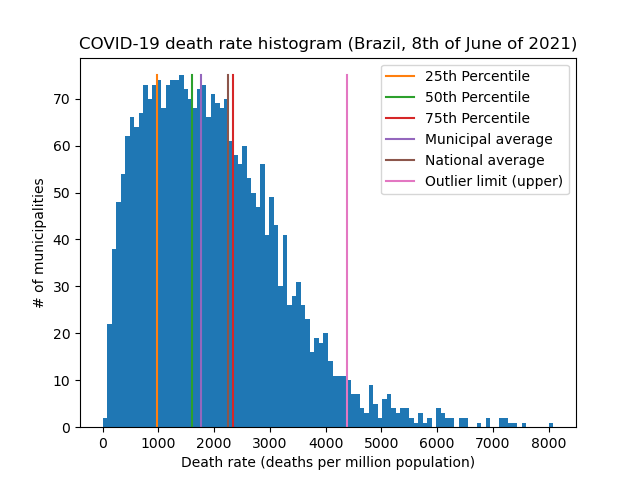

In [15]:
%matplotlib notebook

plot_histogram(death_rates)

# C.2) Boxplot

### The same rightward-skewedness can be observed in a boxplot. The 25th and 75th percentiles are roughly symmetric around the median (50th percentile, orange line), but nonetheless a great number of points outreach the plot's upper whisker.

### The quartile-based method for outlier detection employed in boxplots has a great advantage against methods based on average and standard deviation, because the presence of outliers distort the latter two values, whereas quartiles are insensitive to outliers.

<IPython.core.display.Javascript object>


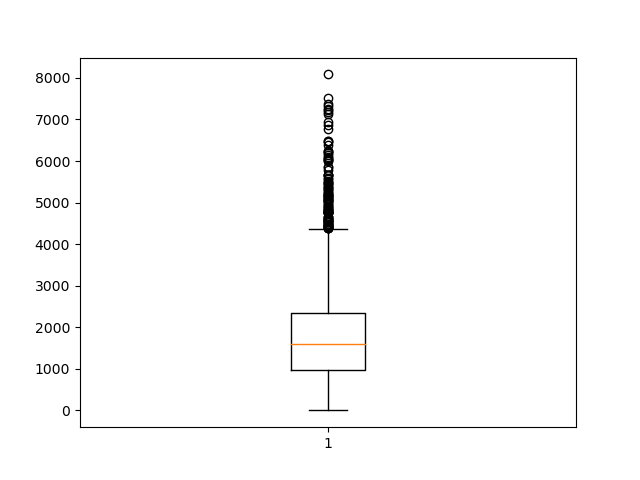

In [16]:
%matplotlib notebook

plt.boxplot(death_rates)
plt.show()

# C.3) Correlation: Population × Death rate

### Let us examine the correlation between population and death rate across municipalities for the 8th of July of 2021. We have already obtained a list of death rates, and we now obtain a list of population sizes.

### We can numerically determine that there is no correlation between the two variables: R ≈ 0.024.

In [17]:
populations = get_values(df, '2021-06-08', 'Population')

In [18]:
def get_correlation(X, Y):
    mu_x = get_mean(X)
    mu_y = get_mean(Y)
    numerator = sum([(x - mu_x) * (y - mu_y) for x,y in zip(X, Y)])
    
    denom_X = sum([(x - mu_x) ** 2 for x in X])
    denom_Y = sum([(y - mu_y) ** 2 for y in Y])
    denominator = math.sqrt(denom_X * denom_Y)
    
    return numerator / denominator

get_correlation(populations, death_rates)

0.0024188907065151527

### We can corroborate our conclusion that there is no correlation between the two variables by performing a linear regression and juxtaposing it to a scatterplot containing the whole data.

In [19]:
def get_coeffs(X, Y):
    std_X = get_std(X)
    std_Y = get_std(Y)
    corr = get_correlation(X, Y)
    slope = corr * (std_Y / std_X)
    
    avg_X = get_mean(X)
    avg_Y = get_mean(Y)
    intercept =  avg_Y - (avg_X * slope)
    
    return intercept, slope

<IPython.core.display.Javascript object>


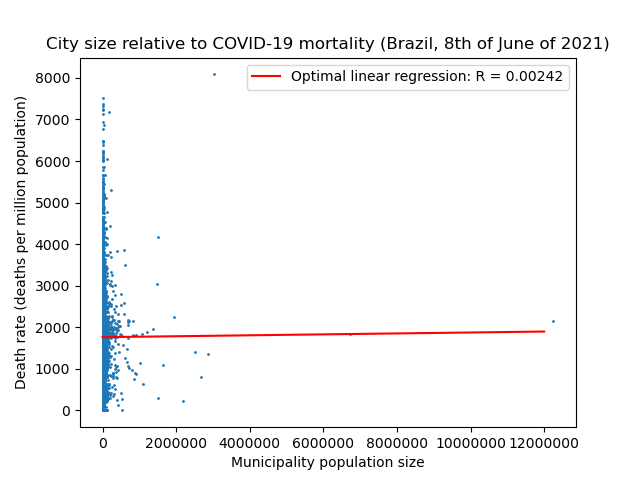

In [20]:
%matplotlib notebook

plt.scatter(populations, death_rates, s=1)
plt.ticklabel_format(style='plain')

plt.title("City size relative to COVID-19 mortality (Brazil, 8th of June of 2021)")
plt.xlabel("Municipality population size")
plt.ylabel("Death rate (deaths per million population)")

intercept, slope = get_coeffs(populations, death_rates)
X = [0, 12000000]
plt.plot(X, [(intercept + slope * x) for x in X], 'red', label=f"Optimal linear regression: R = {get_correlation(populations, death_rates):.5f}")
plt.legend()
plt.show()

# D) Sampling and Estimation

### To practice Statistics 101 tools, we will simulate samplings of our dataset and use them to estimate population properties with confidence intervals. We begin by subsetting our dataset to include only the 8th of July of 2021.

In [21]:
df_dated = df.loc[pd.IndexSlice[:, '2021-06-08'], :]
df_dated.head(5)

,,Population,Total deaths,Total cases,Death rate
City,Date,,,,
Alta Floresta D'Oeste,2021-06-08,22945.0,63.0,3770.0,2745.0
Ariquemes,2021-06-08,107863.0,447.0,20275.0,4144.0
Cabixi,2021-06-08,5312.0,17.0,732.0,3200.0
Cacoal,2021-06-08,85359.0,255.0,12484.0,2987.0
Cerejeiras,2021-06-08,16323.0,57.0,2326.0,3492.0


### Sampling is made easy by the Pandas library.

In [22]:
def get_sample(pop, size, seed):
    return pop.sample(n=size, axis=0, random_state=seed)

## D.1) Multi-sample estimation: The Central Limit Theorem (CLT)

### Population: A random variable (P) with an arbitrary distribution, μ for average value ("avg"), and σ for standard deviation ("std").

### Sample: Consider samples of variable P, each with size _n_. Each sample's average value is itself a random variable (S). The CLT guarantees that, as _n_ increases, and regardless of P's distribution, S's distribution will approximate a normal distribution. Plus, S's avg and std respectively approximate μ and σ / √n.

### The function below, get_sample_distribution(), takes 1000 same-sized samples and obtains each sample's avg. This creates a distribution of sample avgs. The function returns the distribution's avg and std. Note that the distribution's avg is an average of sample averages.

In [23]:
def get_sample_distribution(pop, sample_size, number_of_samples, colname):
    individual_sample_mean_list = list()
    for seed in range(number_of_samples):
        sample = get_sample(pop, sample_size, seed)
        individual_sample_mean = get_mean(sample[colname])
        individual_sample_mean_list.append(individual_sample_mean)
        
    sample_distribution_mean = get_mean(individual_sample_mean_list)
    sample_std = get_std(individual_sample_mean_list)
    return sample_distribution_mean, sample_std

### The function below compares the sample distribution's avg and std to their expected values: μ and σ / √n. There is a correction factor √( (N – n) / (N – 1) ), where N is population size. This factor is close to 1 when N >> n, but becomes significant for n closer to N (e.g. n equal to 5% of N).

In [24]:
def score_multisample(pop, sample_size, number_of_samples, colname):
    pop_mean = get_mean(pop[colname])
    pop_std = get_std(pop[colname])
    
    pop_size = len(pop[colname])
    pop_correction_factor = math.sqrt((pop_size - sample_size) / (pop_size - 1))
    expected_std = (pop_std / math.sqrt(sample_size)) * pop_correction_factor
    
    sample_mean, sample_std = get_sample_distribution(pop, sample_size, number_of_samples, colname)
    
    print(f"{colname.upper()}")
    print(f"[Mean] Population mean = {pop_mean:.2f}, sample mean = {sample_mean:.2f}. Error = {100 * abs((pop_mean - sample_mean) / pop_mean):.5f}%")
    print(f"[Std Dev] Expected std = {expected_std:.2f}, sample std = {sample_std:.2f}. Error = {100 * abs((expected_std - sample_std) / expected_std):.5f}%\n")

### We can see that the Central Limit Theorem works just fine, as it was mathematically guaranteed to do. With a sample size of n = 300, and taking a total of 1000 samples for each variable (Population, Total deaths, etc.), we have obtained between around 1% error in estimating the population mean and std deviation.

In [25]:
sample_size = 300
number_of_samples = 1000
colnames = ['Population', 'Total deaths', 'Total cases', 'Death rate']
for colname in colnames:
    score_multisample(df_dated, sample_size, number_of_samples, colname)

POPULATION
[Mean] Population mean = 37728.39, sample mean = 37994.63. Error = 0.70569%
[Std Dev] Expected std = 12436.80, sample std = 12358.87. Error = 0.62657%

TOTAL DEATHS
[Mean] Population mean = 85.44, sample mean = 85.82. Error = 0.44056%
[Std Dev] Expected std = 36.48, sample std = 35.72. Error = 2.08307%

TOTAL CASES
[Mean] Population mean = 3051.85, sample mean = 3069.10. Error = 0.56495%
[Std Dev] Expected std = 903.80, sample std = 903.03. Error = 0.08440%

DEATH RATE
[Mean] Population mean = 1676.05, sample mean = 1676.78. Error = 0.04338%
[Std Dev] Expected std = 53.76, sample std = 53.51. Error = 0.47099%



## D.2) Single-sample Estimation: Confidence Intervals.

## Objective: To test how often are confidence intervals correct.

### By taking a single, large (n = 300) sample, we can estimate the population avg with a certain degree of confidence ("α"), but only within an interval. Our degree of confidence α is some percentage value; we will consider α = 0.9, α = 0.95, and α = 0.99. That is, we will construct intervals which we are 90%, 95%, and 99% certain that include the true population avg.

### Our objective is to perform a few hundred single-sample estimations and determine how _often_ the true population avg is indeed inside that interval. This serves as a test for the formulae we employ in constructing the intervals. It would be interesting if our 90% intervals only got the answer right 75% of the time!

### We construct our confidence interval based on (i) an _individual sample mean_, (ii) a _sample distribution std estimate_, and (iii) a _z-score_ associated with the confidence level α. The z-score is a standard concept in normal distribution theory; recall that the _sample avg distribution_ is approximately normal and centered on the population avg (μ), as per the Central Limit Theorem.

### The z-score corresponds to an amount of standard deviations. In our case, the z-score is applied as follows. Suppose that α = 0.9. Imagine a symmetric interval centered on the population avg (μ) such that 90% of all sample avgs fall within that interval (illustration below). There are two cut-off lines symmetric around μ, delimiting two symmetrical areas each containing 45% of sample avgs. The distance between the cut-off lines and μ, measured in terms of standard deviations, is the z-score. The z-score for 45%, 47.5%, and 49.5% are respectively 1.645, 1.96, and 2.575 stds, corresponding respectively to α equal to 90%, 95%, and 99%. The z-score for 50% (α = 1) is infinite.

### The confidence interval is set by: (individual sample mean) ± (population std estimate) × (z-score for ½α).

In [26]:
def get_confidence_interval(pop, sample_size, colname, alpha, seed, use_pop_std):
    sample = get_sample(pop, sample_size, seed)
    
    pop_size = len(pop[colname])
    pop_correction_factor = math.sqrt((pop_size - sample_size) / (pop_size - 1))
    if use_pop_std:
        std_to_use = get_std(pop[colname]) # Population std
    else:
        std_to_use = get_std(sample[colname]) # Sample std
    sample_distribution_std_estimated = (std_to_use / math.sqrt(sample_size)) * pop_correction_factor

    z_score = norm.ppf(alpha)

    interval = sample_distribution_std_estimated * z_score
    
    sample_mean = get_mean(sample[colname])
    
    return sample_mean - interval, sample_mean + interval

In [27]:
def test_confidence_interval(use_pop_std):
    sample_size = 300
    number_of_samples = 2000
    colnames = ['Population', 'Total deaths', 'Total cases', 'Death rate']
    
    for colname in colnames:
        print(f"{colname.upper()}")
        pop_mean = get_mean(df_dated[colname])
        
        for alpha in [0.9, 0.95, 0.99]:
            correct_answers = 0
            
            for seed in range(number_of_samples):
                lower, upper = get_confidence_interval(df_dated, sample_size, colname, alpha, seed, use_pop_std)
                if lower <= pop_mean and pop_mean <= upper:
                    correct_answers += 1
            
            correct = correct_answers / number_of_samples
            print(f"\tALPHA: {alpha * 100}%.")
            print(f"\t\tCorrect answers: {correct_answers}. Total samples: {number_of_samples}.")
            print(f"\t\tPercetange of correct answers: {correct * 100:.2f}%. Error = {(correct - alpha) * 100:.2f}%.")
        
        print()

## D.2.1) Sample standard deviation

### The confidence interval formula in get_confidence_interval() uses the _sample distribution std_. By the Central Limit Theory, for sufficiently large samples (usually n ≥ 30) the sample distribution std should be equal to (population std) / (square root of sample size), that is, σ / √n.

### Unfortunately, the population std (σ) isn't always known. Fortunately, our Statistics 101 textbook (reference below) had taught us that, for sufficiently large samples, a sample's standard deviation (s) should be close to the population's standard deviation. That is, s ≈ σ. Therefore, the sample distribution std should be equal to s / √n.

### However, we have tried to obtain confidence intervals by using the value s / √n, and we obtained grossly wrong results. Here is what happened:

In [28]:
test_confidence_interval(False)

POPULATION
	ALPHA: 90.0%.
		Correct answers: 1288. Total samples: 2000.
		Percetange of correct answers: 64.40%. Error = -25.60%.
	ALPHA: 95.0%.
		Correct answers: 1414. Total samples: 2000.
		Percetange of correct answers: 70.70%. Error = -24.30%.
	ALPHA: 99.0%.
		Correct answers: 1612. Total samples: 2000.
		Percetange of correct answers: 80.60%. Error = -18.40%.

TOTAL DEATHS
	ALPHA: 90.0%.
		Correct answers: 1257. Total samples: 2000.
		Percetange of correct answers: 62.85%. Error = -27.15%.
	ALPHA: 95.0%.
		Correct answers: 1365. Total samples: 2000.
		Percetange of correct answers: 68.25%. Error = -26.75%.
	ALPHA: 99.0%.
		Correct answers: 1529. Total samples: 2000.
		Percetange of correct answers: 76.45%. Error = -22.55%.

TOTAL CASES
	ALPHA: 90.0%.
		Correct answers: 1360. Total samples: 2000.
		Percetange of correct answers: 68.00%. Error = -22.00%.
	ALPHA: 95.0%.
		Correct answers: 1509. Total samples: 2000.
		Percetange of correct answers: 75.45%. Error = -19.55%.
	ALPHA: 99

### The results become extremely more accurate when we use the value σ / √n, although they are virtually identical for death rates (last section).

In [29]:
test_confidence_interval(True)

POPULATION
	ALPHA: 90.0%.
		Correct answers: 1807. Total samples: 2000.
		Percetange of correct answers: 90.35%. Error = 0.35%.
	ALPHA: 95.0%.
		Correct answers: 1844. Total samples: 2000.
		Percetange of correct answers: 92.20%. Error = -2.80%.
	ALPHA: 99.0%.
		Correct answers: 1878. Total samples: 2000.
		Percetange of correct answers: 93.90%. Error = -5.10%.

TOTAL DEATHS
	ALPHA: 90.0%.
		Correct answers: 1783. Total samples: 2000.
		Percetange of correct answers: 89.15%. Error = -0.85%.
	ALPHA: 95.0%.
		Correct answers: 1803. Total samples: 2000.
		Percetange of correct answers: 90.15%. Error = -4.85%.
	ALPHA: 99.0%.
		Correct answers: 1900. Total samples: 2000.
		Percetange of correct answers: 95.00%. Error = -4.00%.

TOTAL CASES
	ALPHA: 90.0%.
		Correct answers: 1738. Total samples: 2000.
		Percetange of correct answers: 86.90%. Error = -3.10%.
	ALPHA: 95.0%.
		Correct answers: 1846. Total samples: 2000.
		Percetange of correct answers: 92.30%. Error = -2.70%.
	ALPHA: 99.0%.
		Co

### Having said that, we have ascertained that the aforementioned method for constructing confidence intervals is reasonably accurate.

---
# References

### _Statistics for Business and Economics_ (8th ed.). McClave, Benson, & Sincich (Prentice Hall, 2001).